Handling categorial data

In [1]:
import pandas as pd

In [2]:
df = pd.DataFrame([
    ['green', 'M', 10.1, 'class1'],
    ['red', 'L', 13.5, 'class2'],
    ['blue', 'XL', 15.3, 'class1']
])

In [3]:
df.columns = ['color', 'size', 'price', 'classlabel']

In [4]:
df

,color,size,price,classlabel
0,green,M,10.1,class1
1,red,L,13.5,class2
2,blue,XL,15.3,class1


Mapping ordinal features

In [5]:
size_mapping = {
    'XL': 3,
    'L': 2,
    'M': 1
}

In [6]:
df['size'] = df['size'].map(size_mapping)

In [7]:
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


In [8]:
size_mapping.items()

[('M', 1), ('L', 2), ('XL', 3)]

In [9]:
inv_size_mapping = {v: k for k, v in size_mapping.items()}

In [10]:
inv_size_mapping

{1: 'M', 2: 'L', 3: 'XL'}

In [11]:
import numpy as np

In [12]:
class_mapping = {label: idx for idx,label in enumerate(np.unique(df['classlabel']))}

In [13]:
class_mapping # can be used to manually map the labels to integers

{'class1': 0, 'class2': 1}

Use LabelEncoder to encode class labels

In [14]:
from sklearn.preprocessing import LabelEncoder

In [15]:
class_le = LabelEncoder()

In [16]:
y = class_le.fit_transform(df['classlabel'].values)

In [17]:
y

array([0, 1, 0])

In [18]:
class_le.inverse_transform(y)

array(['class1', 'class2', 'class1'], dtype=object)

Performing one-hot encoding on nominal features

In [19]:
from sklearn.preprocessing import OneHotEncoder

In [20]:
ohe = OneHotEncoder(categorical_features=[0])

In [21]:
X = df[['color', 'size', 'price']].values

In [22]:
X

array([['green', 1L, 10.1],
       ['red', 2L, 13.5],
       ['blue', 3L, 15.3]], dtype=object)

In [23]:
color_le = LabelEncoder()

In [24]:
X[:, 0] = color_le.fit_transform(X[:, 0])

In [25]:
X

array([[1, 1L, 10.1],
       [2, 2L, 13.5],
       [0, 3L, 15.3]], dtype=object)

In [26]:
ohe.fit_transform(X).toarray() # toarray get matrix representation of the sparse matrix

array([[  0. ,   1. ,   0. ,   1. ,  10.1],
       [  0. ,   0. ,   1. ,   2. ,  13.5],
       [  1. ,   0. ,   0. ,   3. ,  15.3]])

New dataset: wine

In [43]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

In [49]:
df_wine.columns = ['Class label', ' Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash'
                   , 'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins'
                   , 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']
print('Class labels', np.unique(df_wine['Class label']))
df_wine.head()

('Class labels', array([1, 2, 3], dtype=int64))


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


Partitioning a dataset in training and test sets

In [50]:
from sklearn.cross_validation import train_test_split

In [55]:
X, y = df_wine.iloc[:, 1:].values, df_wine['Class label'].values

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

Bringing features onto the same scale

In [61]:
from sklearn.preprocessing import StandardScaler

In [62]:
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

Sequential feature selection

In [63]:
# greedy search
# The Sequential Backward Selection (SBS) is not implemented in scikit-learn
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

class SBS():
    def __init__(self, estimator, k_features,
                 scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
        
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
        self.scores_ = [score]
        while dim > self.k_features:
            scores = []
            subsets = []
            for p in combinations(self.indices_, r=dim-1):
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        return self
    
    def transform(self, X):
        return X[:, self.indices_]
    
    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

In [35]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

In [64]:
knn = KNeighborsClassifier(n_neighbors=2)
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

<__main__.SBS instance at 0x0C43CE18>

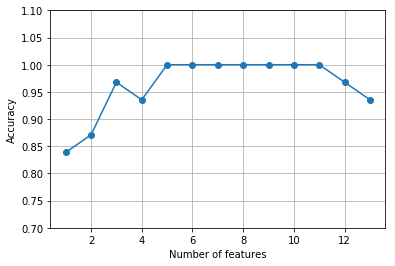

In [66]:
k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.show()

In [69]:
k5 = list(sbs.subsets_[8])

In [71]:
k5

[0, 1, 3, 10, 12]

In [73]:
print(df_wine.columns[1:][k5])

Index([u' Alcohol', u'Malic acid', u'Alcalinity of ash', u'Hue', u'Proline'], dtype='object')


In [76]:
knn.fit(X_train_std[:, k5], y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [77]:
print('Training accuracy:', knn.score(X_train_std[:, k5], y_train))

('Training accuracy:', 0.95967741935483875)


In [78]:
print('Test accuracy:', knn.score(X_test_std[:, k5], y_test))

('Test accuracy:', 0.96296296296296291)


Assessing feature importance with random forests

In [79]:
from sklearn.ensemble import RandomForestClassifier

In [80]:
feat_labels = df_wine.columns[1:]

In [81]:
forest = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [84]:
importances = forest.feature_importances_

In [95]:
indices = np.argsort(importances)[::-1]

In [104]:
for f in range(indices.size):
    print ("%2d) %-*s %f" % (f+1, 30, feat_labels[indices[f]], importances[indices[f]]))

 1) Color intensity                0.182483
 2) Proline                        0.158610
 3) Flavanoids                     0.150948
 4) OD280/OD315 of diluted wines   0.131987
 5)  Alcohol                       0.106589
 6) Hue                            0.078243
 7) Total phenols                  0.060718
 8) Alcalinity of ash              0.032033
 9) Malic acid                     0.025400
10) Proanthocyanins                0.022351
11) Magnesium                      0.022078
12) Nonflavanoid phenols           0.014645
13) Ash                            0.013916


In [105]:
plt.title('Feature importances')

Text(0.5,1,u'Feature importances')

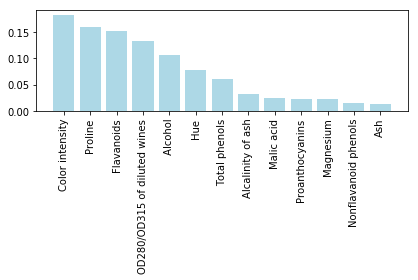

In [117]:
plt.bar(range(X_train.shape[1]),
       importances[indices],
       color='lightblue',
       align='center')
plt.xticks(range(X_train.shape[1]),
          feat_labels[indices], rotation=90)
plt.tight_layout()
plt.show()

Feature selection by random forest model

In [119]:
X_selected = forest.transform(X_train, threshold=0.15)

AttributeError: 'RandomForestClassifier' object has no attribute 'transform'